In [22]:
import pandas as pd
import xarray as xr
import rasterio as rio
import numpy as np
import rioxarray
from glob import glob
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
md_df = pd.read_csv('md_processing_decisions.csv').iloc[:, 0:9]
md_df['survey_name'] = md_df['survey_name'].str.strip()

In [4]:
def mean_aspect(array):
    # Convert to radians
    aspects_rad = np.deg2rad(array)

    # Calculate mean aspect
    sin_mean = np.mean(np.sin(aspects_rad))
    cos_mean = np.mean(np.cos(aspects_rad))
    
    # Convert back to degrees
    mean_aspect = np.rad2deg(np.arctan2(sin_mean, cos_mean))
    
    # Adjust the result to lie between 0 and 360
    if mean_aspect < 0:
        mean_aspect += 360

    return mean_aspect

def std_aspect(array):
    aspects_rad = np.deg2rad(array)

    # Calculate mean aspect in Cartesian coordinates
    sin_mean = np.mean(np.sin(aspects_rad))
    cos_mean = np.mean(np.cos(aspects_rad))
    
    # Calculate the length of the mean resultant vector
    R = np.sqrt(sin_mean**2 + cos_mean**2)
    
    # Calculate the circular standard deviation
    circ_std_dev = np.sqrt(-2 * np.log(R))
    
    # Convert back to degrees
    circ_std_dev_deg = np.rad2deg(circ_std_dev)

    return circ_std_dev_deg

In [5]:
md_area_dic = {}
moving_area_dic = {}
bank_area_dic = {}
landslide_area_dic = {}
elev_mean_dic = {}
aspect_mean_dic = {}
slope_mean_dic = {}

asc_mask_area_dic = {}
des_mask_area_dic = {}
combined_mask_area_dic = {}

asc_coherence_dic = {}
des_coherence_dic = {}
asc_coherence_stable_dic = {}
des_coherence_stable_dic = {}
mean_coherence_change_dic = {}
ice_area_dic = {}
mean_coherence_change_stable_dic = {}
ice_area_stable_dic = {}

asc_veloc_median_dic = {}
des_veloc_median_dic = {}
ud_veloc_median_dic = {}
ew_veloc_median_dic = {}
combined_veloc_median_dic = {}

asc_veloc_mean_dic = {}
des_veloc_mean_dic = {}
ud_veloc_mean_dic = {}
ew_veloc_mean_dic = {}
combined_veloc_mean_dic = {}

asc_veloc_mean_stable_dic = {}
des_veloc_mean_stable_dic = {}
ud_veloc_mean_stable_dic = {}
ew_veloc_mean_stable_dic = {}
combined_veloc_mean_stable_dic = {}

asc_veloc_mean_landslide_dic = {}
des_veloc_mean_landslide_dic = {}
ud_veloc_mean_landslide_dic = {}
ew_veloc_mean_landslide_dic = {}
combined_veloc_mean_landslide_dic = {}

asc_veloc_mean_bank_dic = {}
des_veloc_mean_bank_dic = {}
ud_veloc_mean_bank_dic = {}
ew_veloc_mean_bank_dic = {}
combined_veloc_mean_bank_dic = {}

asc_veloc_75_dic = {}
des_veloc_75_dic = {}
ud_veloc_75_dic = {}
ew_veloc_75_dic = {}
combined_veloc_75_dic = {}

asc_veloc_max_dic = {}
des_veloc_max_dic = {}
ud_veloc_max_dic = {}
ew_veloc_max_dic = {}
combined_veloc_max_dic = {}

asc_veloc_max_stable_dic = {}
des_veloc_max_stable_dic = {}
ud_veloc_max_stable_dic = {}
ew_veloc_max_stable_dic = {}
combined_veloc_max_stable_dic = {}

asc_veloc_max_bank_dic = {}
des_veloc_max_bank_dic = {}
ud_veloc_max_bank_dic = {}
ew_veloc_max_bank_dic = {}
combined_veloc_max_bank_dic = {}

# cop30_ds = xr.open_dataset(f'/home/jovyan/repos/incubator_moraine_dam_analysis/all_dams_analysis/terrain/cop30_utm.tif').squeeze()
# aspect_ds = xr.open_dataset(f'/home/jovyan/repos/incubator_moraine_dam_analysis/all_dams_analysis/terrain/cop30_aspect.tif').squeeze()
# slope_ds = xr.open_dataset(f'/home/jovyan/repos/incubator_moraine_dam_analysis/all_dams_analysis/terrain/cop30_slope.tif').squeeze()

for i, row in md_df.iterrows():
    print(row.survey_name)
    md_gdf = gpd.read_file(f'/home/jovyan/repos/incubator_moraine_dam_analysis/mapping/polygons/{row.survey_name}_md.shp')
    stable_gdf = gpd.read_file(f'/home/jovyan/repos/incubator_moraine_dam_analysis/mapping/polygons/{row.survey_name}_stable.shp').dissolve().to_crs(md_gdf.crs)
    md_area_dic[f'{row.survey_name}'] = md_gdf.area.item()

    # md_gdf_reproj = md_gdf.to_crs(cop30_ds.rio.crs)
    # elev_mean_dic[f'{row.survey_name}'] = cop30_ds.rio.clip(md_gdf_reproj.geometry, crs=md_gdf_reproj.crs).band_data.mean().item()
    # aspect_mean_dic[f'{row.survey_name}'] = mean_aspect(aspect_ds.rio.clip(md_gdf_reproj.geometry, crs=md_gdf_reproj.crs).band_data).item()
    # slope_mean_dic[f'{row.survey_name}'] = slope_ds.rio.clip(md_gdf_reproj.geometry, crs=md_gdf_reproj.crs).band_data.mean().item()

    asc_mask_ds = xr.open_dataset(f'/home/jovyan/repos/incubator_moraine_dam_analysis/dams/{row.survey_name}/{row.survey_name}_asc_valid.tif').squeeze()
    des_mask_ds = xr.open_dataset(f'/home/jovyan/repos/incubator_moraine_dam_analysis/dams/{row.survey_name}/{row.survey_name}_des_valid.tif').squeeze()
    combined_mask_ds = xr.open_dataset(f'/home/jovyan/repos/incubator_moraine_dam_analysis/dams/{row.survey_name}/{row.survey_name}_combined_valid.tif').squeeze()
    asc_mask_area_dic[f'{row.survey_name}'] = np.invert(asc_mask_ds.rio.clip(md_gdf.geometry, crs=md_gdf.crs).band_data.astype('bool')).sum().item()*20*20
    combined_mask_area_dic[f'{row.survey_name}'] = np.invert(combined_mask_ds.rio.clip(md_gdf.geometry, crs=md_gdf.crs).band_data.astype('bool')).sum().item()*20*20
    des_mask_area_dic[f'{row.survey_name}'] = np.invert(des_mask_ds.rio.clip(md_gdf.geometry, crs=md_gdf.crs).band_data.astype('bool')).sum().item()*20*20

    asc_coherence_ds = xr.open_dataset(f'/home/jovyan/repos/incubator_moraine_dam_analysis/dams/{row.survey_name}/{row.survey_name}_asc_mean_coherence.tif').squeeze()
    des_coherence_ds = xr.open_dataset(f'/home/jovyan/repos/incubator_moraine_dam_analysis/dams/{row.survey_name}/{row.survey_name}_des_mean_coherence.tif').squeeze()
    asc_coherence_dic[f'{row.survey_name}'] = asc_coherence_ds.rio.clip(md_gdf.geometry, crs=md_gdf.crs).band_data.mean().item()
    des_coherence_dic[f'{row.survey_name}'] = des_coherence_ds.rio.clip(md_gdf.geometry, crs=md_gdf.crs).band_data.mean().item()
    asc_coherence_stable_dic[f'{row.survey_name}'] = asc_coherence_ds.rio.clip(stable_gdf.geometry, crs=stable_gdf.crs).band_data.mean().item()
    des_coherence_stable_dic[f'{row.survey_name}'] = des_coherence_ds.rio.clip(stable_gdf.geometry, crs=stable_gdf.crs).band_data.mean().item()

    coherence_change_ds = xr.open_dataset(f'/home/jovyan/repos/incubator_moraine_dam_analysis/dams/{row.survey_name}/{row.survey_name}_seasonal_coherence_change.tif').squeeze().rio.write_crs(md_gdf.crs)
    mean_coherence_change_dic[f'{row.survey_name}'] = coherence_change_ds.rio.clip(md_gdf.geometry, crs=md_gdf.crs).band_data.mean().item()
    ice_area_dic[f'{row.survey_name}'] = ((coherence_change_ds.rio.clip(md_gdf.geometry, crs=md_gdf.crs).band_data > 0.03).sum()*20*20).item()
    mean_coherence_change_stable_dic[f'{row.survey_name}'] = coherence_change_ds.rio.clip(stable_gdf.geometry, crs=stable_gdf.crs).band_data.mean().item()
    ice_area_stable_dic[f'{row.survey_name}'] = ((coherence_change_ds.rio.clip(stable_gdf.geometry, crs=stable_gdf.crs).band_data > 0.03).sum()*20*20).item()

    asc_ds = xr.open_dataset(f'/home/jovyan/repos/incubator_moraine_dam_analysis/dams/{row.survey_name}/{row.survey_name}_asc_median_velocity.tif').squeeze()
    des_ds = xr.open_dataset(f'/home/jovyan/repos/incubator_moraine_dam_analysis/dams/{row.survey_name}/{row.survey_name}_des_median_velocity.tif').squeeze()
    ud_ds = xr.open_dataset(f'/home/jovyan/repos/incubator_moraine_dam_analysis/dams/{row.survey_name}/{row.survey_name}_ud_median_velocity.tif').squeeze()
    ew_ds = xr.open_dataset(f'/home/jovyan/repos/incubator_moraine_dam_analysis/dams/{row.survey_name}/{row.survey_name}_ew_median_velocity.tif').squeeze()
    combined_ds = xr.open_dataset(f'/home/jovyan/repos/incubator_moraine_dam_analysis/dams/{row.survey_name}/{row.survey_name}_combined_median_velocity.tif').squeeze()

    asc_veloc_mean_stable_dic[f'{row.survey_name}'] = np.fabs(asc_ds.rio.clip(stable_gdf.geometry, crs=md_gdf.crs).band_data).mean().item()
    des_veloc_mean_stable_dic[f'{row.survey_name}'] = np.fabs(des_ds.rio.clip(stable_gdf.geometry, crs=md_gdf.crs).band_data).mean().item()
    ud_veloc_mean_stable_dic[f'{row.survey_name}'] = ud_ds.rio.clip(stable_gdf.geometry, crs=md_gdf.crs).band_data.mean().item()
    ew_veloc_mean_stable_dic[f'{row.survey_name}'] = np.fabs(ew_ds.rio.clip(stable_gdf.geometry, crs=md_gdf.crs).band_data).mean().item()
    combined_veloc_mean_stable_dic[f'{row.survey_name}'] = combined_ds.rio.clip(stable_gdf.geometry, crs=md_gdf.crs).band_data.mean().item()

    asc_veloc_max_stable_dic[f'{row.survey_name}'] = np.fabs(asc_ds.rio.clip(stable_gdf.geometry, crs=md_gdf.crs).band_data).max().item()
    des_veloc_max_stable_dic[f'{row.survey_name}'] = np.fabs(des_ds.rio.clip(stable_gdf.geometry, crs=md_gdf.crs).band_data).max().item()
    ud_veloc_max_stable_dic[f'{row.survey_name}'] = ud_ds.rio.clip(stable_gdf.geometry, crs=md_gdf.crs).band_data.min().item()
    ew_veloc_max_stable_dic[f'{row.survey_name}'] = np.fabs(ew_ds.rio.clip(stable_gdf.geometry, crs=md_gdf.crs).band_data).max().item()
    combined_veloc_max_stable_dic[f'{row.survey_name}'] = combined_ds.rio.clip(stable_gdf.geometry, crs=md_gdf.crs).band_data.max().item()

    try:
        landslide_gdf = gpd.read_file(f'/home/jovyan/repos/incubator_moraine_dam_analysis/mapping/polygons/{row.survey_name}_landslide.shp').dissolve()
        landslide_area_dic[f'{row.survey_name}'] = landslide_gdf.area.item()

        asc_veloc_mean_landslide_dic[f'{row.survey_name}'] = np.fabs(asc_ds.rio.clip(landslide_gdf.geometry, crs=md_gdf.crs).band_data).mean().item()
        des_veloc_mean_landslide_dic[f'{row.survey_name}'] = np.fabs(des_ds.rio.clip(landslide_gdf.geometry, crs=md_gdf.crs).band_data).mean().item()
        ud_veloc_mean_landslide_dic[f'{row.survey_name}'] = ud_ds.rio.clip(landslide_gdf.geometry, crs=md_gdf.crs).band_data.mean().item()
        ew_veloc_mean_landslide_dic[f'{row.survey_name}'] = np.fabs(ew_ds.rio.clip(landslide_gdf.geometry, crs=md_gdf.crs).band_data).mean().item()
        combined_veloc_mean_landslide_dic[f'{row.survey_name}'] = combined_ds.rio.clip(landslide_gdf.geometry, crs=md_gdf.crs).band_data.mean().item()
    except:
        pass
    
    try:
        moving_gdf = gpd.read_file(f'/home/jovyan/repos/incubator_moraine_dam_analysis/mapping/polygons/{row.survey_name}_moving.shp').dissolve()

        moving_area_dic[f'{row.survey_name}'] = moving_gdf.area.item()
    
        asc_veloc_median_dic[f'{row.survey_name}'] = np.fabs(asc_ds.rio.clip(moving_gdf.geometry, crs=moving_gdf.crs).band_data).median().item()
        des_veloc_median_dic[f'{row.survey_name}'] = np.fabs(des_ds.rio.clip(moving_gdf.geometry, crs=moving_gdf.crs).band_data).median().item()
        ud_veloc_median_dic[f'{row.survey_name}'] = np.fabs(ud_ds.rio.clip(moving_gdf.geometry, crs=moving_gdf.crs).band_data).median().item()
        ew_veloc_median_dic[f'{row.survey_name}'] = np.fabs(ew_ds.rio.clip(moving_gdf.geometry, crs=moving_gdf.crs).band_data).median().item()
        combined_veloc_median_dic[f'{row.survey_name}'] = combined_ds.rio.clip(moving_gdf.geometry, crs=moving_gdf.crs).band_data.median().item()
    
        asc_veloc_mean_dic[f'{row.survey_name}'] = np.fabs(asc_ds.rio.clip(moving_gdf.geometry, crs=moving_gdf.crs).band_data).mean().item()
        des_veloc_mean_dic[f'{row.survey_name}'] = np.fabs(des_ds.rio.clip(moving_gdf.geometry, crs=moving_gdf.crs).band_data).mean().item()
        ud_veloc_mean_dic[f'{row.survey_name}'] = ud_ds.rio.clip(moving_gdf.geometry, crs=moving_gdf.crs).band_data.mean().item()
        ew_veloc_mean_dic[f'{row.survey_name}'] = np.fabs(ew_ds.rio.clip(moving_gdf.geometry, crs=moving_gdf.crs).band_data).mean().item()
        combined_veloc_mean_dic[f'{row.survey_name}'] = combined_ds.rio.clip(moving_gdf.geometry, crs=moving_gdf.crs).band_data.mean().item()
    
        asc_veloc_75_dic[f'{row.survey_name}'] = np.fabs(asc_ds.rio.clip(moving_gdf.geometry, crs=moving_gdf.crs).band_data).quantile(q=0.75).item()
        des_veloc_75_dic[f'{row.survey_name}'] = np.fabs(des_ds.rio.clip(moving_gdf.geometry, crs=moving_gdf.crs).band_data).quantile(q=0.75).item()
        ud_veloc_75_dic[f'{row.survey_name}'] = np.fabs(ud_ds.rio.clip(moving_gdf.geometry, crs=moving_gdf.crs).band_data).quantile(q=0.75).item()
        ew_veloc_75_dic[f'{row.survey_name}'] = np.fabs(ew_ds.rio.clip(moving_gdf.geometry, crs=moving_gdf.crs).band_data).quantile(q=0.75).item()
        combined_veloc_75_dic[f'{row.survey_name}'] = combined_ds.rio.clip(moving_gdf.geometry, crs=moving_gdf.crs).band_data.quantile(q=0.75).item()
    
        asc_veloc_max_dic[f'{row.survey_name}'] = np.fabs(asc_ds.rio.clip(moving_gdf.geometry, crs=moving_gdf.crs).band_data).max().item()
        des_veloc_max_dic[f'{row.survey_name}'] = np.fabs(des_ds.rio.clip(moving_gdf.geometry, crs=moving_gdf.crs).band_data).max().item()
        ud_veloc_max_dic[f'{row.survey_name}'] = ud_ds.rio.clip(moving_gdf.geometry, crs=moving_gdf.crs).band_data.min().item()
        ew_veloc_max_dic[f'{row.survey_name}'] = np.fabs(ew_ds.rio.clip(moving_gdf.geometry, crs=moving_gdf.crs).band_data).max().item()
        combined_veloc_max_dic[f'{row.survey_name}'] = combined_ds.rio.clip(moving_gdf.geometry, crs=moving_gdf.crs).band_data.max().item()
    except:
        pass
    
    try:
        bank_gdf = gpd.read_file(f'/home/jovyan/repos/incubator_moraine_dam_analysis/mapping/polygons/{row.survey_name}_bank_movement.shp').dissolve()

        bank_area_dic[f'{row.survey_name}'] = bank_gdf.area.item()
    
        asc_veloc_mean_bank_dic[f'{row.survey_name}'] = np.fabs(asc_ds.rio.clip(bank_gdf.geometry, crs=bank_gdf.crs).band_data).mean().item()
        des_veloc_mean_bank_dic[f'{row.survey_name}'] = np.fabs(des_ds.rio.clip(bank_gdf.geometry, crs=bank_gdf.crs).band_data).mean().item()
        ud_veloc_mean_bank_dic[f'{row.survey_name}'] = ud_ds.rio.clip(bank_gdf.geometry, crs=moving_gdf.crs).band_data.mean().item()
        ew_veloc_mean_bank_dic[f'{row.survey_name}'] = np.fabs(ew_ds.rio.clip(bank_gdf.geometry, crs=bank_gdf.crs).band_data).mean().item()
        combined_veloc_mean_bank_dic[f'{row.survey_name}'] = combined_ds.rio.clip(bank_gdf.geometry, crs=bank_gdf.crs).band_data.mean().item()
    
        asc_veloc_max_bank_dic[f'{row.survey_name}'] = np.fabs(asc_ds.rio.clip(bank_gdf.geometry, crs=bank_gdf.crs).band_data).max().item()
        des_veloc_max_bank_dic[f'{row.survey_name}'] = np.fabs(des_ds.rio.clip(bank_gdf.geometry, crs=bank_gdf.crs).band_data).max().item()
        ud_veloc_max_bank_dic[f'{row.survey_name}'] = ud_ds.rio.clip(bank_gdf.geometry, crs=bank_gdf.crs).band_data.min().item()
        ew_veloc_max_bank_dic[f'{row.survey_name}'] = np.fabs(ew_ds.rio.clip(bank_gdf.geometry, crs=bank_gdf.crs).band_data).max().item()
        combined_veloc_max_bank_dic[f'{row.survey_name}'] = combined_ds.rio.clip(bank_gdf.geometry, crs=bank_gdf.crs).band_data.max().item()
    except:
        continue

rolpa
barun
imja
lumding
chamlang_south
thugali
nagma
chamlang_north
muli_tal
barun_pokhari
east_hongu_1
birendra
mera
upper_barun
gakal_gl_0008
kotam_gl_0111
east_hongu_2
tallo_kekyap
kekyap
dig
sabai
kodud_gl_0205
hongu_1


In [6]:
md_df['area'] = md_df['survey_name'].map(md_area_dic)
md_df['moving_area'] = md_df['survey_name'].map(moving_area_dic)
md_df['bank_area'] = md_df['survey_name'].map(bank_area_dic)
md_df['landslide_area'] = md_df['survey_name'].map(landslide_area_dic)
# md_df['mean_elevation'] = md_df['survey_name'].map(elev_mean_dic)
# md_df['mean_aspect'] = md_df['survey_name'].map(aspect_mean_dic)
# md_df['mean_slope'] = md_df['survey_name'].map(slope_mean_dic)

md_df['asc_mask_area'] = md_df['survey_name'].map(asc_mask_area_dic)
md_df['des_mask_area'] = md_df['survey_name'].map(des_mask_area_dic)
md_df['combined_mask_area'] = md_df['survey_name'].map(combined_mask_area_dic)

md_df['asc_coherence'] = md_df['survey_name'].map(asc_coherence_dic)
md_df['des_coherence'] = md_df['survey_name'].map(des_coherence_dic)
md_df['asc_coherence_stable'] = md_df['survey_name'].map(asc_coherence_stable_dic)
md_df['des_coherence_stable'] = md_df['survey_name'].map(des_coherence_stable_dic)

md_df['coherence_change_mean'] = md_df['survey_name'].map(mean_coherence_change_dic)
md_df['ice_area'] = md_df['survey_name'].map(ice_area_dic)
md_df['coherence_change_mean_stable'] = md_df['survey_name'].map(mean_coherence_change_stable_dic)
md_df['ice_area_stable'] = md_df['survey_name'].map(ice_area_stable_dic)

md_df['asc_median_veloc'] = md_df['survey_name'].map(asc_veloc_median_dic)
md_df['des_median_veloc'] = md_df['survey_name'].map(des_veloc_median_dic)
md_df['ud_median_veloc'] = md_df['survey_name'].map(ud_veloc_median_dic)
md_df['ew_median_veloc'] = md_df['survey_name'].map(ew_veloc_median_dic)
md_df['combined_median_veloc'] = md_df['survey_name'].map(combined_veloc_median_dic)

md_df['asc_mean_veloc'] = md_df['survey_name'].map(asc_veloc_mean_dic)
md_df['des_mean_veloc'] = md_df['survey_name'].map(des_veloc_mean_dic)
md_df['ud_mean_veloc'] = md_df['survey_name'].map(ud_veloc_mean_dic)
md_df['ew_mean_veloc'] = md_df['survey_name'].map(ew_veloc_mean_dic)
md_df['combined_mean_veloc'] = md_df['survey_name'].map(combined_veloc_mean_dic)

md_df['asc_mean_veloc_stable'] = md_df['survey_name'].map(asc_veloc_mean_stable_dic)
md_df['des_mean_veloc_stable'] = md_df['survey_name'].map(des_veloc_mean_stable_dic)
md_df['ud_mean_veloc_stable'] = md_df['survey_name'].map(ud_veloc_mean_stable_dic)
md_df['ew_mean_veloc_stable'] = md_df['survey_name'].map(ew_veloc_mean_stable_dic)
md_df['combined_mean_veloc_stable'] = md_df['survey_name'].map(combined_veloc_mean_stable_dic)

md_df['asc_mean_veloc_bank'] = md_df['survey_name'].map(asc_veloc_mean_bank_dic)
md_df['des_mean_veloc_bank'] = md_df['survey_name'].map(des_veloc_mean_bank_dic)
md_df['ud_mean_veloc_bank'] = md_df['survey_name'].map(ud_veloc_mean_bank_dic)
md_df['ew_mean_veloc_bank'] = md_df['survey_name'].map(ew_veloc_mean_bank_dic)
md_df['combined_mean_veloc_bank'] = md_df['survey_name'].map(combined_veloc_mean_bank_dic)

md_df['asc_mean_veloc_landslide'] = md_df['survey_name'].map(asc_veloc_mean_landslide_dic)
md_df['des_mean_veloc_landslide'] = md_df['survey_name'].map(des_veloc_mean_landslide_dic)
md_df['ud_mean_veloc_landslide'] = md_df['survey_name'].map(ud_veloc_mean_landslide_dic)
md_df['ew_mean_veloc_landslide'] = md_df['survey_name'].map(ew_veloc_mean_landslide_dic)
md_df['combined_mean_veloc_landslide'] = md_df['survey_name'].map(combined_veloc_mean_landslide_dic)

md_df['asc_75_veloc'] = md_df['survey_name'].map(asc_veloc_75_dic)
md_df['des_75_veloc'] = md_df['survey_name'].map(des_veloc_75_dic)
md_df['ud_75_veloc'] = md_df['survey_name'].map(ud_veloc_75_dic)
md_df['ew_75_veloc'] = md_df['survey_name'].map(ud_veloc_75_dic)
md_df['combined_75_veloc'] = md_df['survey_name'].map(combined_veloc_75_dic)

md_df['asc_max_veloc'] = md_df['survey_name'].map(asc_veloc_max_dic)
md_df['des_max_veloc'] = md_df['survey_name'].map(des_veloc_max_dic)
md_df['ud_max_veloc'] = md_df['survey_name'].map(ud_veloc_max_dic)
md_df['ew_max_veloc'] = md_df['survey_name'].map(ew_veloc_max_dic)
md_df['combined_max_veloc'] = md_df['survey_name'].map(combined_veloc_max_dic)

md_df['asc_max_veloc_stable'] = md_df['survey_name'].map(asc_veloc_max_stable_dic)
md_df['des_max_veloc_stable'] = md_df['survey_name'].map(des_veloc_max_stable_dic)
md_df['ud_max_veloc_stable'] = md_df['survey_name'].map(ud_veloc_max_stable_dic)
md_df['ew_max_veloc_stable'] = md_df['survey_name'].map(ew_veloc_max_stable_dic)
md_df['combined_max_veloc_stable'] = md_df['survey_name'].map(combined_veloc_max_stable_dic)

md_df['asc_max_veloc_bank'] = md_df['survey_name'].map(asc_veloc_max_bank_dic)
md_df['des_max_veloc_bank'] = md_df['survey_name'].map(des_veloc_max_bank_dic)
md_df['ud_max_veloc_bank'] = md_df['survey_name'].map(ud_veloc_max_bank_dic)
md_df['ew_max_veloc_bank'] = md_df['survey_name'].map(ew_veloc_max_bank_dic)
md_df['combined_max_veloc_bank'] = md_df['survey_name'].map(combined_veloc_max_bank_dic)

/tmp/ipykernel_358/674251644.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1, 0].set_xticklabels(labels, rotation=45)
/tmp/ipykernel_358/674251644.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1, 1].set_xticklabels(labels, rotation=45)
/tmp/ipykernel_358/674251644.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1, 2].set_xticklabels(labels, rotation=45)
/tmp/ipykernel_358/674251644.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1, 3].set_xticklabels(labels, rotation=45)


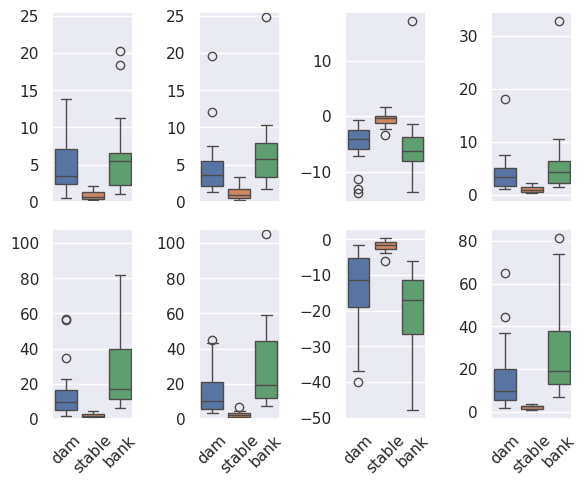

In [59]:
asc_mean = md_df[['asc_mean_veloc', 'asc_mean_veloc_stable', 'asc_mean_veloc_bank']]*100
des_mean = md_df[['des_mean_veloc', 'des_mean_veloc_stable', 'des_mean_veloc_bank']]*100
ud_mean = md_df[['ud_mean_veloc', 'ud_mean_veloc_stable', 'ud_mean_veloc_bank']]*100
ew_mean = md_df[['ew_mean_veloc', 'ew_mean_veloc_stable', 'ew_mean_veloc_bank']]*100
asc_max = md_df[['asc_max_veloc', 'asc_max_veloc_stable', 'asc_max_veloc_bank']]*100
des_max = md_df[['des_max_veloc', 'des_max_veloc_stable', 'des_max_veloc_bank']]*100
ud_max = md_df[['ud_max_veloc', 'ud_max_veloc_stable', 'ud_max_veloc_bank']]*100
ew_max = md_df[['ew_max_veloc', 'ew_max_veloc_stable', 'ew_max_veloc_bank']]*100
labels = ['dam', 'stable', 'bank']

sns.set_theme()

f, ax = plt.subplots(2, 4, figsize=(6, 5))
sns.boxplot(ax=ax[0, 0], data=asc_mean)
ax[0, 0].set_xticklabels('')
ax[0, 0].set_ylim(0, 25.5)
sns.boxplot(ax=ax[0, 1], data=des_mean)
ax[0, 1].set_xticklabels('')
ax[0, 1].set_ylim(0, 25.5)
sns.boxplot(ax=ax[0, 2], data=ud_mean)
ax[0, 2].set_xticklabels('')
sns.boxplot(ax=ax[0, 3], data=ew_mean)
ax[0, 3].set_xticklabels('')
sns.boxplot(ax=ax[1, 0], data=asc_max)
ax[1, 0].set_xticklabels(labels, rotation=45)
ax[1, 0].set_ylim(0, 108)
sns.boxplot(ax=ax[1, 1], data=des_max)
ax[1, 1].set_xticklabels(labels, rotation=45)
ax[1, 1].set_ylim(0, 108)
sns.boxplot(ax=ax[1, 2], data=ud_max)
ax[1, 2].set_xticklabels(labels, rotation=45)
sns.boxplot(ax=ax[1, 3], data=ew_max)
ax[1, 3].set_xticklabels(labels, rotation=45)
plt.tight_layout()


In [ ]:
lake_elev_dic = {
    'rolpa': 4545.5,
    'barun': 4507.5,
    'imja': 4990,
    'lumding': 4831,
    'chamlang_south': 4938,
    'thugali': 3988,
    'nagma': 4910,
    'chamlang_north': 5206,
    'muli_tal': 5577,
    'barun_pokhari': 4808.5,
    'east_hongu_1': 5379.5,
    'birendra': 3623,
    'mera': 5251.5,
    'upper_barun': 5185.5,
    'gakal_gl_0008': 5436,
    'kotam_gl_0111': 4902,
    'east_hongu_2': 5480.5,
    'tallo_kekyap': 5422,
    'kekyap': 5479,
    'dig': 4370,
    'sabai': 4363,
    'kodud_gl_0205': 4759,
    'hongu_1': 5204
}

md_df['lake_elev'] = md_df['survey_name'].map(lake_elev_dic)                                    

In [54]:
pfv_dic = {
    'rolpa': 66.3,
    'barun': 1.5,
    'imja': 0.4,
    'lumding': 21.4,
    'chamlang_south': 9.3,
    'thugali': 0.7,
    'nagma': 0.7,
    'chamlang_north': 29.6,
    'muli_tal': 0.2,
    'barun_pokhari': 0.7,
    'east_hongu_1': 2.6,
    'birendra': 0.7,
    'mera': 2.4,
    'upper_barun': 1.5,
    'gakal_gl_0008': 0.2,
    'kotam_gl_0111': 2.7,
    'east_hongu_2': 2.6,
    'tallo_kekyap': 0.2,
    'kekyap': 0.2,
    'dig': 0.7,
    'sabai': 2.3,
    'kodud_gl_0205': 6.0,
    'hongu_1': 4.6
}

md_df['pfv'] = md_df['survey_name'].map(pfv_dic)

In [9]:
md_df['moving_proportion'] = md_df['moving_area']/md_df['area']
md_df['mean_freeboard'] = md_df['mean_elevation'] - md_df['lake_elev']

In [60]:
md_df['mask_area_proportion'] = md_df['combined_mask_area']/md_df['area']

In [71]:
(md_df.ud_max_veloc*100).mean()

14.556240944397937

In [ ]:
md_df['shapefile_names'] = md_df['survey_name']+'_md'

In [ ]:
md_df.to_csv('md_df.csv')